In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tensorflow import keras
# Geoplots
import descartes
import geopandas as gpd 
from shapely.geometry import Point, Polygon
import geoplot as gplt

## Linear Regression

In [2]:
# Configure plots
sns.set()
plt.rcParams['figure.figsize'] = (9,6) # size in inches 
plt.rcParams['axes.labelpad'] = 10

In [54]:
# Resulsts of linear regression
lr = pd.read_csv("data/keras_regression_results.csv").iloc[:, 1 :]

# Linear regression model
filename = "linear_regression_model.sav"
# lr_model = pickle.load(open(filename, 'rb'))
lr_model = keras.models.load_model('web-app/tf_linear_model_2')

# Entire data set
data = pd.read_csv("data/complete_data.csv")
# Drop demographics data
demographics = ['less_than_$50,000_(%)', 'between_$50,000_and_$80,000_(%)', 
                'between_$80,000_and_$100,000_(%)', 'between_$100,000_and_$150,000_(%)',
                'more_than_$150,000_(%)', '1-person_households_(%)', 
                '2-person_households_(%)', '3-person_households_(%)', 
                '4-person_households_(%)', '5-person_or_more_households_(%)', 
                'couples_without_children_at_home_(%)', 'couples_with_children_at_home_(%)',
                'single-parent_families_(%)', 'owners_(%)', 'renters_(%)',
                'before_1960_(%)', 'between_1961_and_1980_(%)',
                'between_1981_and_1990_(%)', 'between_1991_and_2000_(%)',
                'between_2001_and_2010_(%)', 'between_2011_and_2016_(%)',
                'single-family_homes_(%)', 'semi-detached_or_row_houses_(%)',
                'buildings_with_less_than_5_floors_(%)',
                'buildings_with_5_or_more_floors_(%)', 'mobile_homes_(%)',
                'university_(%)', 'college_(%)', 'secondary_(high)_school_(%)',
                'apprentice_or_trade_school_diploma_(%)', 'no_diploma_(%)',
                'non-immigrant_population_(%)', 'immigrant_population_(%)',
                'french_(%)', 'english_(%)', 'others_languages_(%)',
                'new_area_from_price', 'new_area_from_rooms', 'basement_bedroom']
data.drop(demographics, axis=1, inplace=True)
actual = data[['price']]
actual.columns = ["actual"]
features = data.iloc[:, 7 :]

In [55]:
features.info()
features.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2854 entries, 0 to 2853
Data columns (total 34 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   restaurants                              2854 non-null   float64
 1   shopping                                 2854 non-null   float64
 2   vibrant                                  2854 non-null   float64
 3   cycling_friendly                         2854 non-null   float64
 4   car_friendly                             2854 non-null   float64
 5   historic                                 2854 non-null   float64
 6   quiet                                    2854 non-null   float64
 7   elementary_schools                       2854 non-null   float64
 8   high_schools                             2854 non-null   float64
 9   parks                                    2854 non-null   int64  
 10  nightlife                                2854 no

Index(['restaurants', 'shopping', 'vibrant', 'cycling_friendly',
       'car_friendly', 'historic', 'quiet', 'elementary_schools',
       'high_schools', 'parks', 'nightlife', 'groceries', 'daycares',
       'pedestrian_friendly', 'cafes', 'transit_friendly', 'greenery',
       'year_built', 'population_2016_',
       'population_variation_between_2011_2016_', 'population_density_',
       'unemployment_rate_2016_', 'walk_score', 'rooms', 'bedrooms',
       'bathrooms', 'powder_rooms', 'total_area', 'river_proximity',
       'has_pool', 'n_parking', 'has_garage', 'is_devided', 'mr_distance'],
      dtype='object')

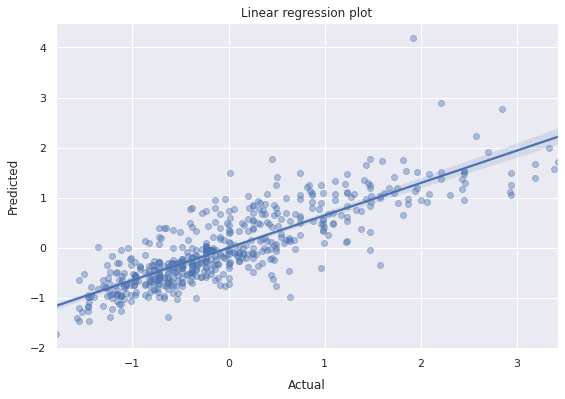

In [56]:
# Regression plot 
sns.regplot('Actual', 'Predicted', lr, scatter_kws={'alpha':0.4})
plt.title("Linear regression plot")
plt.savefig('figures/lr_plot.png', bbox_inches='tight', dpi=300)

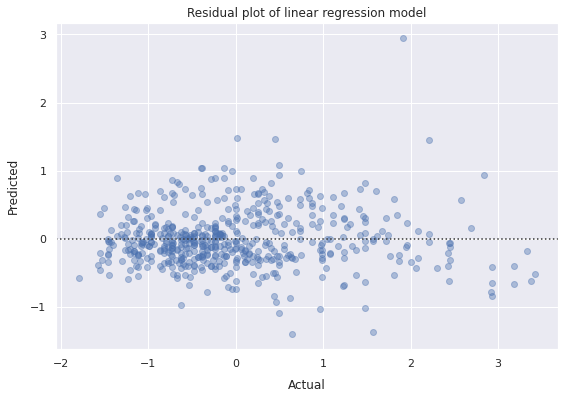

In [57]:
# Residuals plot
sns.residplot('Actual', 'Predicted', lr, scatter_kws={'alpha':0.4})
plt.title("Residual plot of linear regression model")
plt.savefig('figures/lr_residuals.png', bbox_inches='tight', dpi=300)

From the previous figures it seemed that 1.2 million dollars might be a good cutoff for the model. After this value, prediction errors increase. This is most likely because of omitted features that become more important for expensive condos such as quality of materials used for constructione.

## Predictions on entire set

In [58]:
# Z-score normalization
feature_means = features.mean()
feature_stds = features.std()
features_norm = (features - feature_means)/feature_stds

# Add unnormalized boolean features back as 1 and 0
boolean_features = ['river_proximity', 'has_pool',
                    'has_garage']
for bool_feature in boolean_features:
    features_norm[bool_feature] = features[bool_feature].apply(
                    lambda x: 1 if (x == True) else 0
    )

# features to numpy array
feature_array = features_norm.to_numpy()

In [59]:
features_norm.columns

Index(['restaurants', 'shopping', 'vibrant', 'cycling_friendly',
       'car_friendly', 'historic', 'quiet', 'elementary_schools',
       'high_schools', 'parks', 'nightlife', 'groceries', 'daycares',
       'pedestrian_friendly', 'cafes', 'transit_friendly', 'greenery',
       'year_built', 'population_2016_',
       'population_variation_between_2011_2016_', 'population_density_',
       'unemployment_rate_2016_', 'walk_score', 'rooms', 'bedrooms',
       'bathrooms', 'powder_rooms', 'total_area', 'river_proximity',
       'has_pool', 'n_parking', 'has_garage', 'is_devided', 'mr_distance'],
      dtype='object')

In [60]:
# Dataframe of actual prices, predictions and differences between the two
data_predictions = actual.copy()
# Predict price
pred = lr_model.predict(feature_array)
# Add predictions to data frame
data_predictions["predictions"] = pred
# Convert Z-score predictions back to $$$
price_std = float(actual.std())
price_mean = float(actual.mean())
data_predictions["predictions"] = data_predictions["predictions"]*price_std + price_mean
# Differences: actual - predicted
data_predictions["diff"] = data_predictions.actual - data_predictions.predictions
# Add differences to data
data["diff"] = data_predictions["diff"]
# data_predictions sorted by differences
sorted_by_diff = data_predictions.sort_values(by="diff", ascending=False)
sorted_by_diff

,actual,predictions,diff
1372,15435000,5768820.00,9666180.00
1371,13435000,4998576.50,8436423.50
1399,8990000,3480136.00,5509864.00
2823,8500000,3275343.25,5224656.75
1440,7190000,2451983.50,4738016.50
...,...,...,...
1979,1265000,2786692.50,-1521692.50
2789,1199000,2772648.75,-1573648.75
936,890000,2771747.00,-1881747.00
2736,499000,2477209.50,-1978209.50


Text(0.5, 1.0, 'Linear regression plot')

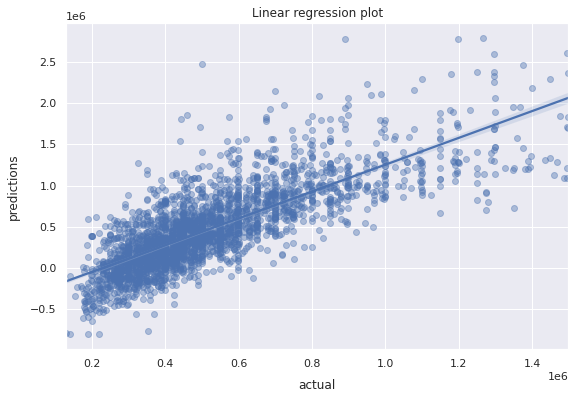

In [61]:
# Regression plot without outliers
sns.regplot('actual', 'predictions', data_predictions[data_predictions.actual < 1500000], scatter_kws={'alpha':0.4})
plt.title("Linear regression plot")
# plt.savefig('figures/lr_plot.png', bbox_inches='tight', dpi=300)

In [14]:
data.to_csv('data/data_with_prediction_differences.csv')

Differences between actual and pridicted prices are expected to increase with the price of a listing. Therefore, it is better to remove outlier especially if those are outside the scope of an indeviduals budget.

In [72]:
def top_false_estimates(budget, sorted_listings):
    """
    Returns indices of top 300 underestimated/overestimeated            listings below a specified budget. Requires list sorted by          differences in descending order.
    """

    data = sorted_listings[sorted_listings["actual"] <= budget]
    # Top 300
    underestimates = data.head(300).index
    overestimates = data.tail(300).index
    return (underestimates, overestimates)

In [73]:
top_indices = top_false_estimates(budget=600000, sorted_listings=sorted_by_diff)
# Top overestimates
overestimate_indices = top_indices[1]
top_overestimates = data.iloc[overestimate_indices, 1 :]
# Overestimate labels
top_overestimates['overestimate'] = [1 for i in range(top_overestimates.shape[0])]
top_overestimates_coordinates = data.iloc[overestimate_indices, 2 : 4]

# Top underestimates
underestimate_indices = top_indices[0]
top_underestimate = data.iloc[underestimate_indices, 1 :]
# Underestimate labels
top_underestimate['overestimate'] = [0 for i in range(top_underestimate.shape[0])]
top_underestimate_coordinates = data.iloc[underestimate_indices, 2 : 4]

In [74]:
# Sum of differences
top_underestimate['diff'].sum()

131404515.90625

In [75]:
# Merge over and underestimates
false_estimates = pd.concat([top_overestimates, top_underestimate], axis=0)
false_estimates

,index,title,address,price,lat,long,restaurants,shopping,vibrant,cycling_friendly,...,powder_rooms,total_area,river_proximity,has_pool,n_parking,has_garage,is_devided,mr_distance,diff,overestimate
932,1599,Condo for sale,"3154, Rue Sainte-Catherine Est, Montréal (Merc...",459000,45.538705,-73.541480,9.0,8.0,7.0,10.0,...,1.0,1380.0,False,False,1.0,False,1,5.820595,-183638.6250,1
1018,1762,Condo for sale,"7565, Chemin Westover, apt. 402, Montréal (Côt...",429000,45.459581,-73.657367,5.0,6.0,3.0,4.0,...,0.0,1211.0,False,False,1.0,True,1,6.808675,-184804.3125,1
1771,3079,Condo for sale,"5186, Rue Saint-Denis, Montréal (Le Plateau-Mo...",547000,45.527370,-73.590989,10.0,10.0,10.0,10.0,...,0.0,1044.0,False,False,1.0,False,1,2.596559,-185065.1250,1
1369,2373,Condo for sale,"3111, Rue Victoria, Montréal (Lachine), Neighb...",362000,45.436615,-73.690991,5.0,6.0,3.0,7.0,...,1.0,1043.0,False,True,1.0,True,1,10.466017,-185095.7500,1
2500,4541,Condo for sale,"2455, Rue des Nations, apt. 304, Montréal (Sai...",559000,45.513785,-73.710653,6.0,7.0,3.0,7.0,...,0.0,1123.0,False,False,2.0,True,1,8.830215,-185767.6875,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,1744,Condo for sale,"1405, Rue Antoine-Déat, apt. 6, Montréal (Ahun...",289500,45.562530,-73.645071,7.0,8.0,4.0,9.0,...,0.0,981.0,False,False,1.0,True,1,7.412022,320866.3125,0
1848,3226,Condo for sale,"4119, Avenue Madison, apt. 1, Montréal (Côte-d...",269000,45.467007,-73.627267,8.0,8.0,5.0,6.0,...,0.0,637.0,False,False,0.0,False,1,4.754194,320620.7500,0
1501,2604,Condo for sale,"2190, Rue Préfontaine, apt. 107, Montréal (Mer...",334900,45.540783,-73.550348,9.0,8.0,7.0,9.0,...,0.0,738.0,False,False,1.0,True,1,5.483429,320223.6875,0
258,438,Condo for sale,"5400, 16e Avenue, apt. 2, Montréal (Rosemont/L...",259800,45.554525,-73.571483,9.0,9.0,7.0,8.0,...,0.0,654.0,False,False,0.0,False,1,5.930498,319720.1250,0


## Geo-Visualization of Top Listings

In [76]:
# Montreal road map from shapefile
street_map = gpd.read_file("montreal_shape/roads.shp")

In [77]:
# coordinate reference system
crs = {'init': 'epsg:4326'}
geometry = [Point(x,y) for x, y in zip(false_estimates['long'], false_estimates['lat'])]
geometry[: 3]

In [78]:
# Initialize geo data frame
geo_df = gpd.GeoDataFrame(false_estimates, crs=crs, geometry=geometry)
geo_df.tail()

,index,title,address,price,lat,long,restaurants,shopping,vibrant,cycling_friendly,...,total_area,river_proximity,has_pool,n_parking,has_garage,is_devided,mr_distance,diff,overestimate,geometry
1010,1744,Condo for sale,"1405, Rue Antoine-Déat, apt. 6, Montréal (Ahun...",289500,45.562530,-73.645071,7.0,8.0,4.0,9.0,...,981.0,False,False,1.0,True,1,7.412022,320866.3125,0,POINT (-73.64507 45.56253)
1848,3226,Condo for sale,"4119, Avenue Madison, apt. 1, Montréal (Côte-d...",269000,45.467007,-73.627267,8.0,8.0,5.0,6.0,...,637.0,False,False,0.0,False,1,4.754194,320620.7500,0,POINT (-73.62727 45.46701)
1501,2604,Condo for sale,"2190, Rue Préfontaine, apt. 107, Montréal (Mer...",334900,45.540783,-73.550348,9.0,8.0,7.0,9.0,...,738.0,False,False,1.0,True,1,5.483429,320223.6875,0,POINT (-73.55035 45.54078)
258,438,Condo for sale,"5400, 16e Avenue, apt. 2, Montréal (Rosemont/L...",259800,45.554525,-73.571483,9.0,9.0,7.0,8.0,...,654.0,False,False,0.0,False,1,5.930498,319720.1250,0,POINT (-73.57148 45.55452)
1235,2153,Condo for sale,"1827, Rue Grand Trunk, Montréal (Le Sud-Ouest)...",325000,45.481982,-73.561671,10.0,10.0,7.0,10.0,...,787.0,False,False,0.0,False,0,3.790239,319719.5000,0,POINT (-73.56167 45.48198)


In [79]:
# Plot geo data frame
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df[geo_df.overestimate == 1].plot(ax=ax, markersize=20, color='blue', marker='o', label='Overestimate')
geo_df[geo_df.overestimate == 0].plot(ax=ax, markersize=20, color='red', marker='^', label='Underestimate')
plt.title("Top 300 over and under estimated Montreal real estate listings below $600K")
plt.legend()
plt.savefig('figures/lr_underAndOverestimates.png', bbox_inches='tight', dpi=300)
plt.close() # to decrease size of notebook

Next, we will implement a color gradient based on the `diff` feature in `sorted_by_diff`. Colors that stand out in particular regions that are dominated by colors at the opposite end of the scale might be of interest for investors.

In [80]:
# New geometry
geometry = [Point(x,y) for x, y in zip(data['long'], data['lat'])]
# New geo data frame
geo_df = gpd.GeoDataFrame(data, crs=crs, geometry=geometry).iloc[:, 1 :]

In [81]:
# Reduce outliers exceeding differences of +-400k
# For better results with color mapping
geo_df["diff_balanced"] = geo_df["diff"].\
    apply(lambda x: 400000 if x > 400000 else (-400000 if x < -400000 else x))

In [82]:
# Color pallette
# cmap = sns.cubehelix_palette(as_cmap="True", dark=0.1, light=0.95)
cmap = sns.color_palette("vlag", as_cmap=True)

In [83]:
# Plot geo data frame
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.2, color='grey')
#geo_df.plot(ax=ax, c=geo_df["diff"], cmap=cmap, markersize=5, marker='o', legend=True)
gplt.pointplot(geo_df, ax=ax, hue="diff_balanced", cmap=cmap, legend=True)
plt.title("Mapped price differences (actual - predicted)")
plt.savefig('figures/lr_mappedAccuracies.png', bbox_inches='tight', dpi=300)
plt.close() # to decrease size of notebook


## Cluster Neighbourhood Data

In this section we will first reduce the number of neighbourhood features using PCA. This will increase the performance of Kmeans which will be applied to the transformed data to aggregate and label each record. The labels will then be used to gether with geographical coordinates to visualize different types of neighbourhoods. Further analysis may reveal dominant neighbourhood patterns that correlate well with other features. Most interesting would be a correlation to the `population_variation_between_2011_2016_` feature. A similar analysis will be performed on the demographic data to identify `up-and-coming neighbourhoods`. 

In [84]:
data = pd.read_csv("data/complete_data.csv")

In [109]:
neighbourhood_data = ['restaurants',
       'shopping', 'vibrant', 'cycling_friendly', 'car_friendly', 'historic',
       'quiet', 'elementary_schools', 'high_schools', 'parks', 'nightlife',
       'groceries', 'daycares', 'pedestrian_friendly', 'cafes',
       'transit_friendly', 'greenery']

# Slice neighbourhood and demographic data 
neighbourhoods = data[neighbourhood_data]
# Standardize data
x = StandardScaler().fit_transform(neighbourhoods)

# PCA
pca = PCA()
pca.fit(x)
explained_variance = pca.explained_variance_
print(explained_variance)

[9.53361317 1.93609421 1.43952436 0.76224111 0.5701485  0.53803756
 0.52043477 0.44997345 0.36834509 0.24029544 0.22924291 0.15036678
 0.09863122 0.07264219 0.04726009 0.02797462 0.02113318]


Text(0, 0.5, 'Percent explained')

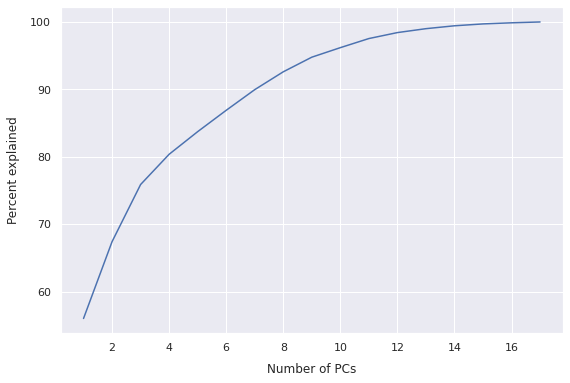

In [110]:
# Plot explained variance
n_pcs = range(1, 18)
y = 100*(explained_variance/explained_variance.sum())
# Transform to commulative sum of explained percentage
for i in range(len(y)):
    if i > 0:
        y[i] = y[i -1] + y[i]
plt.plot(n_pcs, y)
plt.xlabel("Number of PCs")
plt.ylabel("Percent explained")

In [111]:
# PCA
pca = PCA(n_components=2)
pca_transform = pca.fit_transform(x)

# K-means
k_means = KMeans(n_clusters=5)
k_means.fit(pca_transform)

KMeans(n_clusters=5)

In [112]:
# Plot axese 
axis_1 = pca_transform[:, 0]
axis_2 = pca_transform[:, 1]

Text(0, 0.5, 'PCA2')

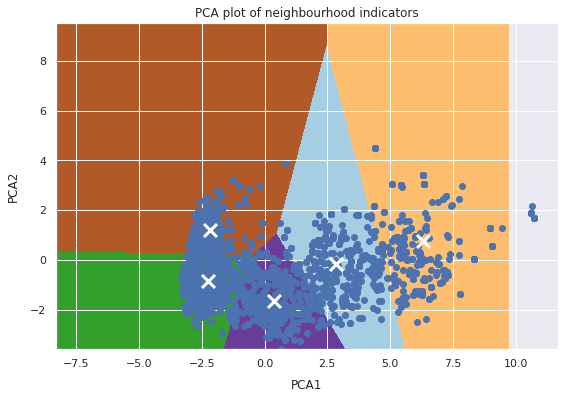

In [113]:
# 2D PCA plot with Kmeans clusters
x_min, x_max = axis_1.min() - 5, pca_transform[:, 0].max() - 1
y_min, y_max = axis_2.min(), pca_transform[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = k_means.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
          extent=(xx.min(), xx.max(), yy.min(), yy.max()),
          cmap=plt.cm.Paired,
          aspect='auto', origin='lower')
plt.scatter(axis_1, axis_2)
centroids = k_means.cluster_centers_
inert = k_means.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1],
           marker='x', s=169, linewidths=3,
           color='w', zorder=8)
plt.title("PCA plot of neighbourhood indicators")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

In [114]:
print(abs( pca.components_ )[0])

[0.30915416 0.29877236 0.30695168 0.09477488 0.27091798 0.28203634
 0.16202535 0.11089951 0.15042596 0.2213804  0.29634866 0.25129918
 0.18023709 0.29047052 0.30414306 0.29542826 0.03485335]


Top neighbourhood indicators according to PCA1 components: `'restaurants', 'shopping', 'vibrant', 'nightlife','pedestrian_friendly', 'cafes', 'transit_friendly'`. 
 
This likely differentiates downtown areas from suburbs. Next we will increase the number of PCAs so that at least 80% of the variance is explained. We will then use Kmeans to cluser and label data.

In [115]:
def required_pcs(explained_variance):
    """Prints the amount of principle components needed to explain
    at least 80% of the variance in the data."""
    above_85 = False
    i = 0
    percent_var = 0

    # Find number of PCs to explain 80% variance
    while above_85 == False:
        total_variance = sum(explained_variance)
        percent_var += 100*(explained_variance[i]/total_variance)
        i += 1
        if percent_var >= 85:
            above_85 = True
    print("Number of PCs to explain 85% of variance:", i)
    print("Variance explained by {} PCs".format(i), percent_var, "%")

In [116]:
required_pcs(explained_variance)

Number of PCs to explain 85% of variance: 6
Variance explained by 6 PCs 86.90870778508834 %


In [117]:
# PCA fitting to data
pca = PCA()
pca.fit(x)

PCA()

In [121]:
# PCA tranformation of features
pca = PCA(n_components=6)
pca_transform = pca.fit_transform(x)

# K-means fitting to pca transformations
k_means = KMeans(n_clusters=5)
k_means.fit(pca_transform)

KMeans(n_clusters=5)

In [122]:
# Components of first 6 PCs
components = abs( pca.components_ )[: 6]
print(abs( pca.components_ )[: 6])

[[0.30915416 0.29877236 0.30695168 0.09477488 0.27091798 0.28203634
  0.16202535 0.11089951 0.15042596 0.2213804  0.29634866 0.25129918
  0.18023709 0.29047052 0.30414306 0.29542826 0.03485335]
 [0.07282525 0.07589103 0.12266413 0.17751962 0.12473531 0.00247091
  0.30857259 0.53557452 0.3617473  0.08342084 0.16343594 0.12644191
  0.26359581 0.12589357 0.14353362 0.06300715 0.50431386]
 [0.05994174 0.0114748  0.07835565 0.66588004 0.15308023 0.1177071
  0.39903491 0.09283746 0.42527797 0.17556053 0.08951844 0.13142976
  0.25970011 0.01544267 0.04822707 0.12876536 0.13432845]
 [0.13872945 0.17744044 0.05008982 0.13162462 0.15979273 0.10773764
  0.19310634 0.21169807 0.1596577  0.27406649 0.05964565 0.01760157
  0.5230758  0.03923778 0.01112404 0.11890246 0.64521925]
 [0.12331247 0.25779142 0.10371674 0.09112369 0.00392967 0.16682056
  0.49319028 0.04545236 0.10372057 0.29007985 0.13117836 0.36368202
  0.39390904 0.29994719 0.07974098 0.17468284 0.31582874]
 [0.02658439 0.04672984 0.20381

In [29]:
def print_components(pc_n, feature_labels, components):
    """
    Returns data frame of component names and values of
    the n'th principle compenent
    """
    df = pd.DataFrame(columns=["feature", "pca_score"])
    for i in range(len(feature_labels)):
        pc_components = components[pc_n - 1] # n'th PC
        score = pc_components[i]
        label = feature_labels[i]
        new = pd.DataFrame({"feature" : label, "pca_score" : score}, index=[0])
        df = df.append(new, ignore_index=True)
    return  df

In [30]:
# PC1 components
pc_scores = print_components(pc_n=1, feature_labels=neighbourhood_data, components=components)
pc_scores.sort_values(by="pca_score", ascending=False)

,feature,pca_score
0,restaurants,0.310104
2,vibrant,0.307357
14,cafes,0.303899
1,shopping,0.298424
10,nightlife,0.296383
15,transit_friendly,0.294472
13,pedestrian_friendly,0.290020
5,historic,0.281646
4,car_friendly,0.272978
11,groceries,0.250957


In [31]:
# PC2 components
pc_scores = print_components(pc_n=2, feature_labels=neighbourhood_data, components=components)
pc_scores.sort_values(by="pca_score", ascending=False)

,feature,pca_score
7,elementary_schools,0.532991
16,greenery,0.512169
8,high_schools,0.367055
6,quiet,0.301546
12,daycares,0.261188
3,cycling_friendly,0.177710
10,nightlife,0.159938
14,cafes,0.144191
13,pedestrian_friendly,0.128099
2,vibrant,0.120300


In [32]:
# PC3 components
pc_scores = print_components(pc_n=3, feature_labels=neighbourhood_data, components=components)
pc_scores.sort_values(by="pca_score", ascending=False)

,feature,pca_score
3,cycling_friendly,0.653773
8,high_schools,0.422698
6,quiet,0.413862
12,daycares,0.263667
9,parks,0.166702
4,car_friendly,0.152168
16,greenery,0.139790
11,groceries,0.135275
15,transit_friendly,0.134773
5,historic,0.124220


In [33]:
# PC4 components
pc_scores = print_components(pc_n=4, feature_labels=neighbourhood_data, components=components)
pc_scores.sort_values(by="pca_score", ascending=False)

,feature,pca_score
16,greenery,0.629781
12,daycares,0.550507
9,parks,0.241708
7,elementary_schools,0.224093
1,shopping,0.188155
6,quiet,0.176106
8,high_schools,0.160068
4,car_friendly,0.143612
0,restaurants,0.137234
3,cycling_friendly,0.135772


*Neighbourhood aggregats*  
PC1:  -> vibrant, urban life  
PC2:  -> family friendly, green, moderately vibrant and quiet  
PC3:  -> cycling friendly, older children and quiet (boring)   
PC4:  -> young children and green (very boring)

In [1]:
# PC5 components
pc_scores = print_components(pc_n=5, feature_labels=neighbourhood_data, components=components)
pc_scores.sort_values(by="pca_score", ascending=False)

NameError: name 'print_components' is not defined

In [ ]:
# PC6 components
pc_scores = print_components(pc_n=6, feature_labels=neighbourhood_data, components=components)
pc_scores.sort_values(by="pca_score", ascending=False)

## Cluster Demographics Data  

The objective of this section would be to identify up and coming neighbourhoods in combination with the data from the previous section.

In [123]:
demographic_data = ['less_than_$50,000_(%)',
       'between_$50,000_and_$80,000_(%)', 'between_$80,000_and_$100,000_(%)',
       'between_$100,000_and_$150,000_(%)', 'more_than_$150,000_(%)',
       '1-person_households_(%)', '2-person_households_(%)',
       '3-person_households_(%)', '4-person_households_(%)',
       '5-person_or_more_households_(%)',
       'couples_without_children_at_home_(%)',
       'couples_with_children_at_home_(%)', 'single-parent_families_(%)',
       'owners_(%)', 'renters_(%)', 'before_1960_(%)',
       'between_1961_and_1980_(%)', 'between_1981_and_1990_(%)',
       'between_1991_and_2000_(%)', 'between_2001_and_2010_(%)',
       'between_2011_and_2016_(%)', 'single-family_homes_(%)',
       'semi-detached_or_row_houses_(%)',
       'buildings_with_less_than_5_floors_(%)',
       'buildings_with_5_or_more_floors_(%)', 'mobile_homes_(%)',
       'university_(%)', 'college_(%)', 'secondary_(high)_school_(%)',
       'apprentice_or_trade_school_diploma_(%)', 'no_diploma_(%)',
       'non-immigrant_population_(%)', 'immigrant_population_(%)',
       'french_(%)', 'english_(%)', 'others_languages_(%)']

# Slice neighbourhood and demographic data 
demographics = data[demographic_data]
# Standardize data
x = StandardScaler().fit_transform(demographics)

In [124]:
# PCA
pca = PCA()
pca.fit(x)
explained_variance = pca.explained_variance_
print(explained_variance)

[1.50469953e+01 6.40485405e+00 5.10012084e+00 3.69322450e+00
 1.51425654e+00 1.15030901e+00 8.99553539e-01 6.55549751e-01
 4.46642731e-01 4.22487874e-01 2.71810449e-01 1.72137571e-01
 9.61728580e-02 6.76703079e-02 3.81395621e-02 2.10979525e-02
 9.38278915e-03 2.21263228e-03 4.30708647e-30 1.23049118e-30
 7.36817474e-31 6.06465507e-31 4.59599169e-31 4.18071137e-31
 2.43083288e-31 1.25363475e-31 9.66813403e-32 9.66813403e-32
 9.66813403e-32 9.66813403e-32 9.66813403e-32 9.66813403e-32
 9.66813403e-32 9.66232953e-32 1.69332521e-32 4.57084944e-33]


In [125]:
required_pcs(explained_variance)

Number of PCs to explain 85% of variance: 5
Variance explained by 5 PCs 88.18978673362321 %


In [37]:
pca_components = abs( pca.components_ )[: 4]
print(pca_components)

[[0.20142479 0.23059323 0.234939   0.20360778 0.0081203  0.24760239
  0.07827218 0.23950481 0.24374825 0.22413034 0.23264131 0.22585262
  0.13939814 0.21809593 0.21809593 0.05691095 0.09102231 0.11457168
  0.0375595  0.07992023 0.10673648 0.19355607 0.21291931 0.06266066
  0.19585496 0.03349179 0.21187168 0.15497305 0.19773182 0.18054488
  0.19989539 0.00991968 0.00991968 0.00270463 0.03928746 0.05517663]
 [0.01174799 0.11475539 0.0547105  0.02943497 0.17318815 0.06287273
  0.12632078 0.0704842  0.076598   0.12209139 0.00647248 0.05959488
  0.17563341 0.07469089 0.07469089 0.21189443 0.10157646 0.08393117
  0.22663527 0.23277243 0.04348274 0.11181278 0.08212587 0.3237311
  0.23033133 0.04055936 0.10462801 0.02650562 0.06019479 0.17071229
  0.13027885 0.3119949  0.3119949  0.32934424 0.25434266 0.28968477]
 [0.15423864 0.06840549 0.11940291 0.20348007 0.14385682 0.04703145
  0.2694529  0.09430866 0.08576615 0.11316434 0.16865201 0.14678013
  0.1452483  0.19652152 0.19652152 0.13048407 0

In [38]:
# PC1 components
print_components(demographics_data, pc_n = 1)

SyntaxError: positional argument follows keyword argument (<ipython-input-38-52f01cc9209f>, line 2)